In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,"../")

from src.masked.kernel import VFTSGaussKernel,TSGaussGaussKernel
from src.masked.loss import VarifoldLoss
from src.masked.lddmm import Shooting,Flowing
from src.plotting import plot2Dfigure

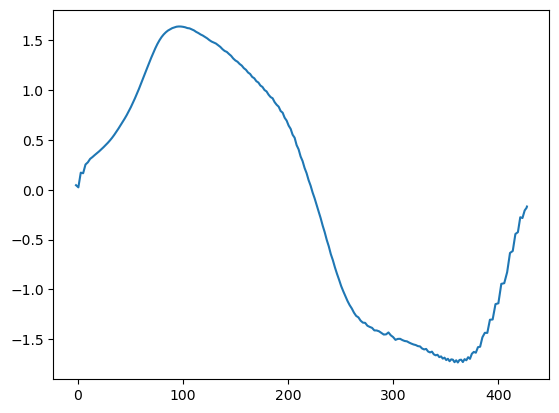

In [13]:
np.random.seed(0)

y =pd.read_csv("./dataset/y.csv",index_col=0)
X = np.load("./dataset/X.npy")
X_mask = np.load("./dataset/X_mask.npy")
idxs = np.load("./results/exp_1_0/idxs.npy")
X,X_mask = X[idxs],X_mask[idxs]
X,X_mask = X[:,::2,:],X_mask[:,::2,:]
y = y.iloc[idxs]



p0s = np.load("./results/exp_1_0/p0s.npy")
q0 = np.load("./results/exp_1_0/q0.npy")
q0_mask = np.load("./results/exp_1_0/q0_mask.npy")
p0s = p0s.reshape(-1,p0s.shape[2],p0s.shape[3])
plt.plot(*q0[q0_mask.squeeze(),:].T)

In [3]:
np.sum(q0_mask)

349

(<Figure size 1000x500 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

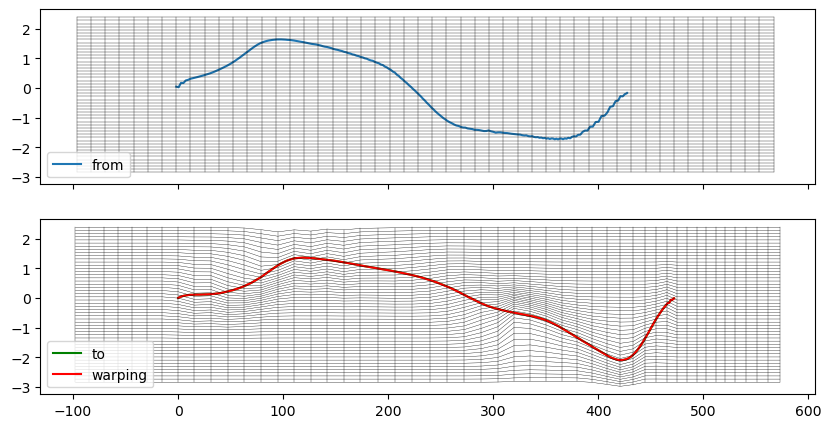

In [14]:
Kv = VFTSGaussKernel(1,0.1,100,1,1)
Kl = TSGaussGaussKernel(2,1,2,0.6)
dataloss = VarifoldLoss(Kl)

shoot = Shooting(Kv)
flow = Flowing(Kv)

plot2Dfigure(q0,X[0],p0s[0],shoot,flow,q0_mask,X_mask[0])

In [5]:
p0s.shape

(1050, 1000, 2)

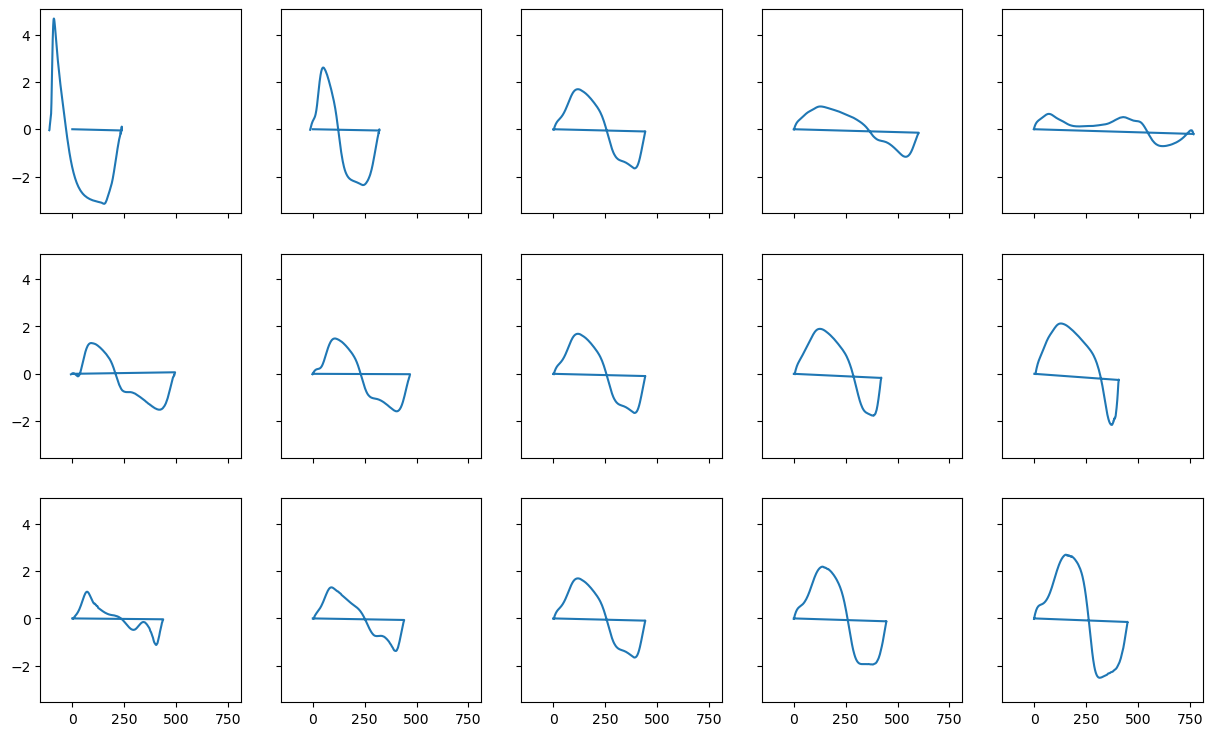

In [16]:
from src.statistic import MomentaPCA
ncomp,ndisp = 3,5
mpca = MomentaPCA(ncomp,masked=True)
mpca.fit(Kv,p0s,q0,q0_mask)

p0_bar = mpca.m_ps_
k = 1

fig,axs = plt.subplots(ncomp,ndisp,figsize = (ndisp*3,ncomp*3),sharex=True,sharey=True)
for pca_index in range(ncomp):
    sigma_pca = np.std(mpca.p_score_[:,pca_index])
    for alpha in np.linspace(-3*sigma_pca , 3*sigma_pca, ndisp):
        p0_mode = p0_bar + alpha * mpca.p_pc_[pca_index]
        p,q = shoot(p0_mode,q0,q0_mask)
        plt.subplot(ncomp,ndisp,k)        
        plt.plot(*q.T)
        k += 1
plt.show()

In [17]:
df = y.copy()
df[[f"PC_{i}" for i in range(ncomp)]] = mpca.p_score_
tdf = df[["start","before"]]
max_before = tdf[tdf.before == "Y"].start.max()
tdf.loc[tdf.before == "N","start"] = tdf[tdf.before == "N"].start.copy().values + max_before
tdf.loc[:,"start"] /= (2000.*60.)
df["time"] = tdf.start
df

,filename,genotype,before,start,end,PC_0,PC_1,PC_2,time
3256,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,225591,226064,30.324703,-12.032320,-4.651245,1.879925
3408,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,2065136,2065561,-33.254433,-4.943746,-0.494594,17.209467
3345,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,1295651,1296035,-73.281273,5.063362,-24.602438,10.797092
3336,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,1194516,1194945,-23.850719,-7.874161,-11.396433,9.954300
3415,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,2139917,2140322,-49.356976,1.314148,-16.539072,17.832642
...,...,...,...,...,...,...,...,...,...
12306,"20161214_wt#31_physo0,33_i5_e60_ep30.EDF",wt,Y,752806,753097,-156.544769,65.410263,-16.160854,6.273383
12266,"20161214_wt#31_physo0,33_i5_e60_ep30.EDF",wt,Y,298939,299250,-171.286972,20.548794,-18.472256,2.491158
12290,"20161214_wt#31_physo0,33_i5_e60_ep30.EDF",wt,Y,591395,591757,-107.085327,9.243517,-2.277839,4.928292
12427,"20161214_wt#31_physo0,33_i5_e60_ep30.EDF",wt,Y,2221605,2221865,-192.319489,70.664398,-41.994438,18.513375


In [18]:
import seaborn as sns

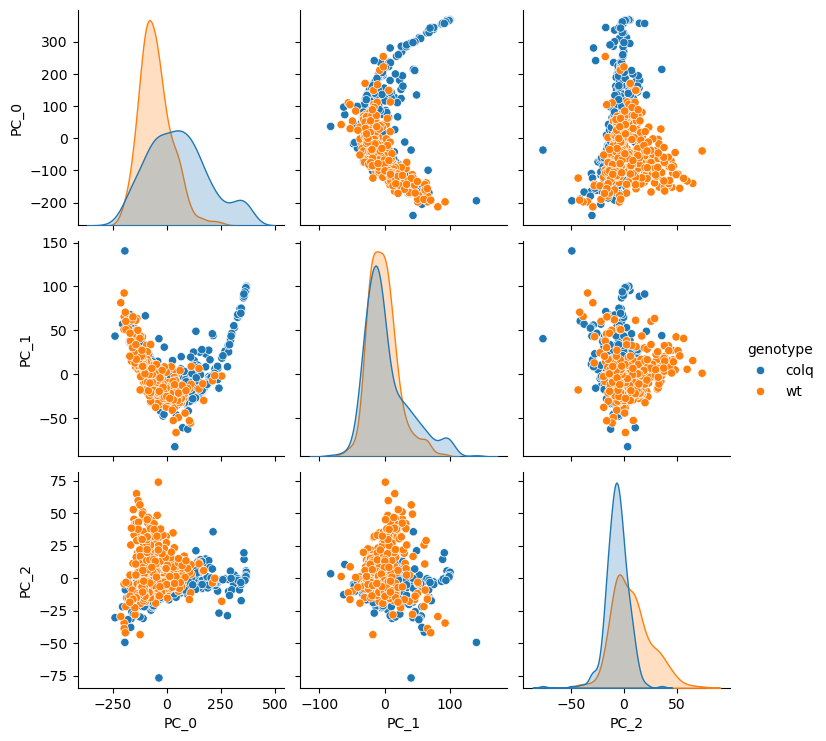

In [19]:
sns.pairplot(df,hue = "genotype",vars=[f"PC_{i}" for i in range(ncomp)])